In [1]:
from IPython import display

from utils import Logger

import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

from torchvision import transforms, datasets

In [2]:
DATA_FOLDER = './torch_data/DCGAN/MNIST'

In [3]:
CONTINUE_TRAINING = False

In [4]:
N_RUN = 1

## Load Data

In [5]:
def mnist_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [6]:
data = mnist_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

## Networks

In [7]:
if CONTINUE_TRAINING:
    pretrained_model_D = "data/models/DCGAN/MNIST/D_epoch_" + str((N_RUN-1) * 100 - 1)
    pretrained_model_G = "data/models/DCGAN/MNIST/G_epoch_" + str((N_RUN-1) * 100 - 1)

In [8]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

In [9]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [10]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [11]:
use_cuda = True

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [12]:
# Create Network instances and init weights
generator = GenerativeNet().to(device)
generator.apply(init_weights)
if CONTINUE_TRAINING:
    discriminator.load_state_dict(torch.load(pretrained_model_D, map_location='cuda'))

discriminator = DiscriminativeNet().to(device)
discriminator.apply(init_weights)
if CONTINUE_TRAINING:
    generator.load_state_dict(torch.load(pretrained_model_G, map_location='cuda'))

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

## Optimization

In [13]:
# Optimizers
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 100

## Training

In [14]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [15]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1. Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake
    return (0, 0, 0)

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Start training

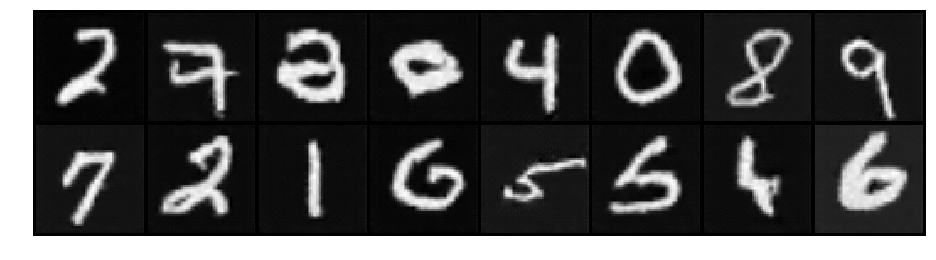

Epoch: [41/100], Batch Num: [0/600]
Discriminator Loss: 0.1428, Generator Loss: 3.6092
D(x): 0.9751, D(G(z)): 0.1014


In [ ]:
logger = Logger(model_name='DCGAN', data_name='MNIST')

d_error_epochs = []
g_error_epochs = []

for epoch in range((N_RUN-1) * 100, (N_RUN-1) * 100 + num_epochs):
    
    d_error_batches = []
    g_error_batches = []
    
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs * N_RUN, n_batch, num_batches,
                float(d_error), float(g_error), d_pred_real, d_pred_fake
            )
            
        d_error_batches.append(d_error.tolist())
        g_error_batches.append(g_error.tolist())
        
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)
    
    d_error_epochs.append(d_error_batches)
    g_error_epochs.append(g_error_batches)

In [ ]:
import numpy as np

d_pred_real_array = np.array(d_pred_real.tolist())
d_pred_real_array = d_pred_real_array.reshape(d_pred_real_array.shape[0])

d_pred_fake_array = np.array(d_pred_fake.tolist())
d_pred_fake_array = d_pred_fake_array.reshape(d_pred_fake_array.shape[0])

In [ ]:
import csv

csvfile = "dcgan_mnist_d_error_" + str(N_RUN * 100) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(d_error_epochs)
    
csvfile = "dcgan_mnist_g_error_" + str(N_RUN * 100) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(g_error_epochs)
    
csvfile = "dcgan_mnist_d_pred_real_" + str(N_RUN * 100) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in d_pred_real_array:
        writer.writerow([val])
        
csvfile = "dcgan_mnist_d_pred_fake_" + str(N_RUN * 100) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in d_pred_fake_array:
        writer.writerow([val])

In [ ]:
d_error_epochs_array = np.array(d_error_epochs)
new_d_error_epochs_array = np.array([np.mean(d_error_epochs_array[i,:]) for i in range(d_error_epochs_array.shape[0])])

g_error_epochs_array = np.array(g_error_epochs)
new_g_error_epochs_array = np.array([np.mean(g_error_epochs_array[i,:]) for i in range(g_error_epochs_array.shape[0])])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(range(d_error_epochs_array.shape[0]), new_d_error_epochs_array, LineWidth=2, label='discriminator')
plt.plot(range(g_error_epochs_array.shape[0]), new_g_error_epochs_array, LineWidth=2, label='generator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('dcgan_mnist_loss_' + str(N_RUN * 100) + '.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(range(d_pred_real_array.shape[0]), d_pred_real_array, LineWidth=2, label='real')
plt.plot(range(d_pred_fake_array.shape[0]), d_pred_fake_array, LineWidth=2, label='fake')
plt.xlabel('Epoch')
plt.ylabel('Uncertainty')
plt.grid(True)
plt.legend()
plt.savefig('dcgan_mnist_loss_uncertainty_' + str(N_RUN * 100) + '.pdf', format='pdf', dpi=300)
plt.show()